# Predictive modelling for predicting prices of apartments in Brazil

### Import Data

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [3]:
path = r"C:\Users\Sanjo\Downloads\properati-BR-2016-11-01-properties-sell.csv\properati-BR-2016-11-01-properties-sell.csv"

### Explore Data

In [7]:
# df.shape
# x = df[df['place_with_parent_names'].str.contains('Minas Gerais')]

In [8]:
# x['place_with_parent_names'].str.strip('|').str.split('|').str[-1]

In [9]:
# df.head()

In [10]:
# df.info()

In [11]:
# df['price_aprox_usd'].describe()

In [12]:
# df['price_aprox_usd'].quantile([0.0, 0.25, 0.50, 0.75, 1])

In [13]:
# df['property_type'].unique()

In [73]:
def wrangle(csv_path):
    df = pd.read_csv(csv_path)
    
    # filtering to property_type='apartment'
    mask_pt = df['property_type']=='apartment'
    
    # filtering to apartmets with prices less than $ 200000
    mask_price = df['price_aprox_usd']<200000
    
    # filtering to 'Minas Gerais' area
    mask_place = df['place_with_parent_names'].str.contains('Minas Gerais')
    
    df = df[mask_pt & mask_price & mask_place]
    
    # Splitting 'lat-lon' column into two separate columns
    df[['lat','lon']] = df['lat-lon'].str.split(',', expand=True).astype('float')
    df.drop(columns='lat-lon', inplace=True)
    
    # removing outliers
    high, low = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = df['surface_covered_in_m2'].between(high, low)
    df = df[mask_area]
    
    # Creating neighborhood column
    df['neighborhood'] = df['place_with_parent_names'].str.strip('|').str.split('|').str[-1]
    df.drop(columns='place_with_parent_names', inplace=True)
    
    # Drop columns with low cardinality
    # low_card_col = [col for col in df.select_dtypes('object').columns if df.col.nunqiue()<10]
    df.drop(columns=['operation', 'property_type', 'currency'], inplace=True)

    # Drop columns with High cardinality
    #  high_card_col = [col for col in df.select_dtypes('object').columns if df.col.nunique()>1000]
    df.drop(columns=['created_on','place_name','geonames_id','surface_total_in_m2','properati_url','description','rooms','expenses','floor','title','image_thumbnail'], inplace=True)
    
    # Drop columns with more then 50% null values
    # df.dropna(thresh=0.5*len(df), axis=1, inplace=True)
    
    # Drop columns which are highly correlated ie. multicollinear features
    
    # Drop leaky columns
    df.drop(columns=['price', 'price_aprox_local_currency', 'price_usd_per_m2', 'price_per_m2'], inplace=True)
    
    return df

In [50]:
df = wrangle(path)

In [51]:
df.shape

(8881, 5)

Text(0.5, 1.0, 'Distribution of Area in Minas Gerais')

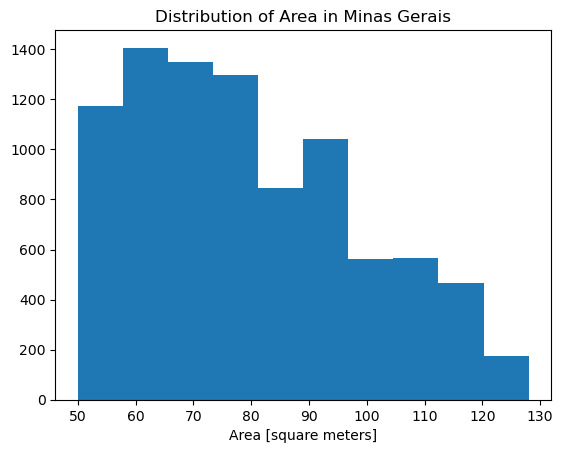

In [89]:
plt.hist(df['surface_covered_in_m2'])
plt.xlabel('Area [square meters]')
plt.title('Distribution of Area in Minas Gerais')

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8881 entries, 21481 to 872308
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    2851 non-null   float64
 1   lon                    2851 non-null   float64
 2   price_aprox_usd        8881 non-null   float64
 3   surface_covered_in_m2  8881 non-null   float64
 4   neighborhood           8881 non-null   object 
dtypes: float64(4), object(1)
memory usage: 416.3+ KB


In [75]:
## Check for multicollinearity & drop those that have more nulls than the other

In [70]:
corr = df.select_dtypes('number').drop(columns='price_aprox_usd').corr()
corr

,lat,lon,surface_covered_in_m2
lat,1.000000,-0.052442,0.005877
lon,-0.052442,1.000000,0.089159
surface_covered_in_m2,0.005877,0.089159,1.000000


<AxesSubplot:>

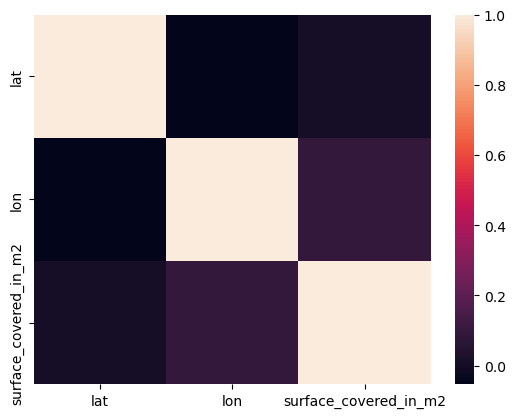

In [72]:
sns.heatmap(corr)

In [56]:
df.isnull().sum()

lat                      6030
lon                      6030
price_aprox_usd             0
surface_covered_in_m2       0
neighborhood                0
dtype: int64

### Splitting the data

In [57]:
X = df[['neighborhood', 'lat', 'lon', 'surface_covered_in_m2']]
y = df['price_aprox_usd']

In [58]:
X.shape, y.shape

((8881, 4), (8881,))

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [60]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7104, 4), (7104,), (1777, 4), (1777,))

In [61]:
X_train['neighborhood'].nunique()

103

### Create a pipeline

In [62]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [63]:
ohe = OneHotEncoder(cols=['neighborhood'],use_cat_names=True)

In [64]:
lin = LinearRegression()

In [65]:
model = make_pipeline(ohe, imp_mean, lin)

### Fit the model on training set

In [66]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

### Make predictions on test set

In [102]:
y_pred_training = model.predict(X_train)

In [67]:
y_test_pred = model.predict(X_test)

### Evaluate the model

In [103]:
mae_train = mean_absolute_error(y_train, y_pred_training)
print("traning mae (LinearRegression Model): ", mae_train)

traning mae (LinearRegression Model):  20487.246291765954


In [99]:
mae = mean_absolute_error(y_test, y_test_pred)
print("LinearRegression model : MAE =: ", round(mae,2))

LinearRegression model : MAE =:  20919.27


#### Ideally, you want your test performance metrics to be the same as its training performance metrics. In practice, test metrics tend to be a little worse (this means a larger number in the case of mean absolute error). But as long as the training and test performance are close to each other, you can be confident that your model will generalize well. 

In [76]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [86]:
make_prediction(110, -34.60, -58.46, "Uberaba")

C:\Users\Sanjo\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


'Predicted apartment price: $547774.14'

In [91]:
coefficients = model.named_steps['linearregression'].coef_
# coefficients
features = model.named_steps['onehotencoder'].get_feature_names_out()
# features
feat_imp = pd.Series(data=coefficients, index=features)
feat_imp

neighborhood_Cidade Nova        9386.479871
neighborhood_Jardim América     6135.389758
neighborhood_Belo Horizonte     7643.616739
neighborhood_Uberaba          -21650.912098
neighborhood_Pouso Alegre     -33333.214710
                                   ...     
neighborhood_São Paulo        -17859.974084
neighborhood_Cinquentenário   -11519.247571
lat                            -4263.222908
lon                             4171.360686
surface_covered_in_m2            929.518016
Length: 106, dtype: float64

### Below horizontal bar chart that shows the 10 most influential coefficients for my model. 

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

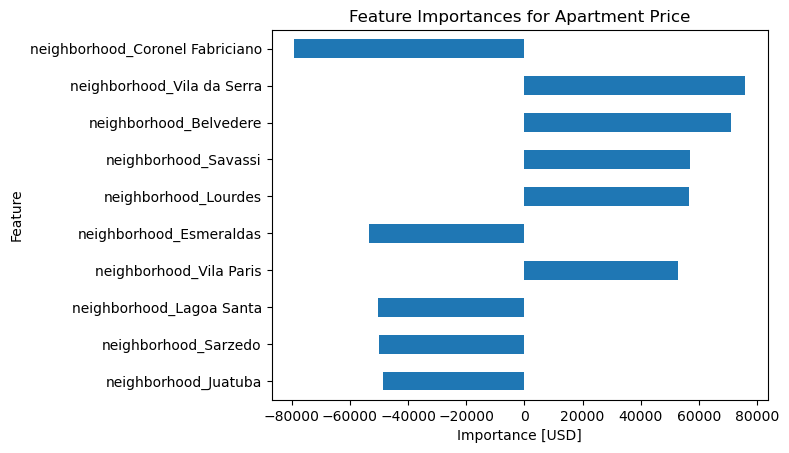

In [93]:
feat_imp.sort_values(key=abs).tail(10).plot(kind='barh')

# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title('Feature Importances for Apartment Price')
